In [65]:
{-# LANGUAGE FlexibleContexts #-}
{-# LANGUAGE FlexibleInstances #-}
{-# LANGUAGE OverloadedStrings #-}
{-# LANGUAGE TypeSynonymInstances #-}
:extension NoMonomorphismRestriction
:extension GADTs

import Syntax
import Infer
import Parser
import Pretty
import Eval
import qualified Env
import DbExp hiding (Lam)

import Data.Monoid
import qualified Data.Map as Map
import qualified Data.Text.Lazy as L
import qualified Data.Text.Lazy.IO as L

import Control.Monad.Identity
import Control.Monad.State.Strict
import Control.Monad.Writer
import Control.Comonad (extend)

import Data.Tree
import Text.PrettyPrint

import qualified Diagrams.Prelude as D
import Diagrams.Prelude hiding (render)
import Diagrams.TwoD.Layout.Tree

In [66]:
gimme ex = cf2tree $ extend (nf . cf2db) ex
  where
    cf2db cf =
      case unwrap cf of
        Lit (LInt n) -> L (LI n)
        Lit (LBool b) -> L (LB b)
        Var x -> V x
        App m n -> cf2db m :@ cf2db n
        Lam x body -> x ! cf2db body

    cf2tree expr =
      case unwrap expr of
        App fun arg -> BNode (render . ppr 0 $ extract expr) (cf2tree fun) (cf2tree arg)
        Lam v body  -> BNode (render . ppr 0 $ extract expr) (leaf ("\\" ++ v)) (cf2tree body)
        Lit w       -> leaf $ render (ppr 0 w) ++ ": " ++ render (ppr 0 $ extract expr)
        Var v       -> leaf $ v ++ ": " ++ render (ppr 0 $ extract expr)

In [81]:
gimmeTypes ex = let Right (_, _, _, tt_subs, _, _) = constraintsExpr Env.empty ex
                 in cf2tree tt_subs
  where
    cf2db cf =
      case unwrap cf of
        Lit (LInt n) -> L (LI n)
        Lit (LBool b) -> L (LB b)
        Var x -> V x
        App m n -> cf2db m :@ cf2db n
        Lam x body -> x ! cf2db body

    cf2tree expr =
      case unwrap expr of
        App fun arg -> BNode (render . ppr 0 $ extract expr) (cf2tree fun) (cf2tree arg)
        Lam v body  -> BNode (render . ppr 0 $ extract expr) (leaf ("\\" ++ v)) (cf2tree body)
        Lit w       -> leaf $ render (ppr 0 w) ++ ": " ++ render (ppr 0 $ extract expr)
        Var v       -> leaf $ v ++ ": " ++ render (ppr 0 $ extract expr)

In [82]:
comp = lam "f" (lam "g" (lam "x" (app (var "f") (app (var "g") (var "x")))))
k3 = lam "saidILovedYouButILied" (lit $ LInt 3)
ident = lam "x" (var "x")
ex2 = app (app (app comp k3) ident) (lit $ LInt 7)
ex3 = app (lam "f" (app (var "f") (var "f"))) (lam "x" (var "x"))
ex4 = app (var "x") (var "x")

In [83]:
-- testTerm = fmap Just $ either (leaf . show) gimme $ parseExpr (L.pack "(\\x. x) y")
testTerm = Just <$> gimmeTypes ex2

In [84]:
Just sentTree = uniqueXLayout 2 2 testTerm

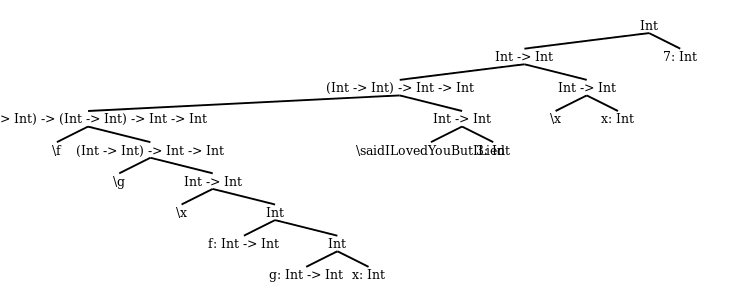

In [85]:
diagram $ pad 1.1 . centerXY
        $ renderTree'
            (maybe mempty $ (lw none (rect 3 1.5) D.<>) . fontSizeL 0.6 . font "freeserif" . D.text)
            (\(a,p1) (b,p2) ->
              maybe p1 (const $ p1 # translate (0 ^& (-0.5))) a
              ~~
              maybe p2 (const $ p2 # translate (0 ^& 0.5)) b)
            sentTree

In [71]:
3+7

10